In [178]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb

from datetime import date
from workalendar.europe import UnitedKingdom

%matplotlib inline

In [179]:
train = pd.read_csv("train_aWnotuB.csv")
test = pd.read_csv("test_BdBKkAj.csv")
sample_sub = pd.read_csv("sample_submission_EZmX9uE.csv")

In [180]:
train.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [181]:
test.head()

,DateTime,Junction,ID
0,2017-07-01 00:00:00,1,20170701001
1,2017-07-01 01:00:00,1,20170701011
2,2017-07-01 02:00:00,1,20170701021
3,2017-07-01 03:00:00,1,20170701031
4,2017-07-01 04:00:00,1,20170701041


In [182]:
train.Junction.value_counts()

3    14592
2    14592
1    14592
4     4344
Name: Junction, dtype: int64

In [183]:
train.DateTime = pd.to_datetime(train.DateTime)
test.DateTime = pd.to_datetime(test.DateTime)

In [184]:
train = train [train.DateTime > '2016-01-01 00:00:00']

train.DateTime.describe()

count                   43725
unique                  13127
top       2017-06-29 20:00:00
freq                        4
first     2016-01-01 01:00:00
last      2017-06-30 23:00:00
Name: DateTime, dtype: object

In [185]:
train.Vehicles.describe()

count    43725.000000
mean        23.925512
std         21.269728
min          1.000000
25%          9.000000
50%         16.000000
75%         31.000000
max        180.000000
Name: Vehicles, dtype: float64

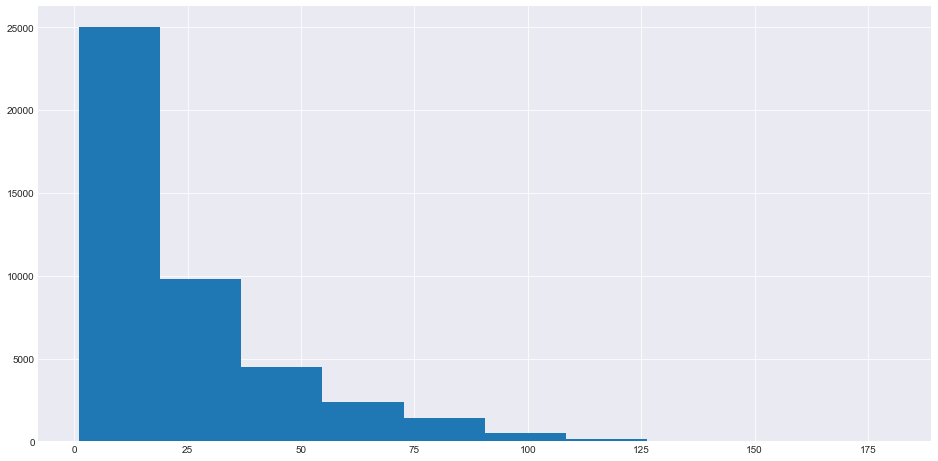

In [186]:
sns.set_style("darkgrid")
plt.figure(figsize = (16,8))

train.Vehicles.hist()

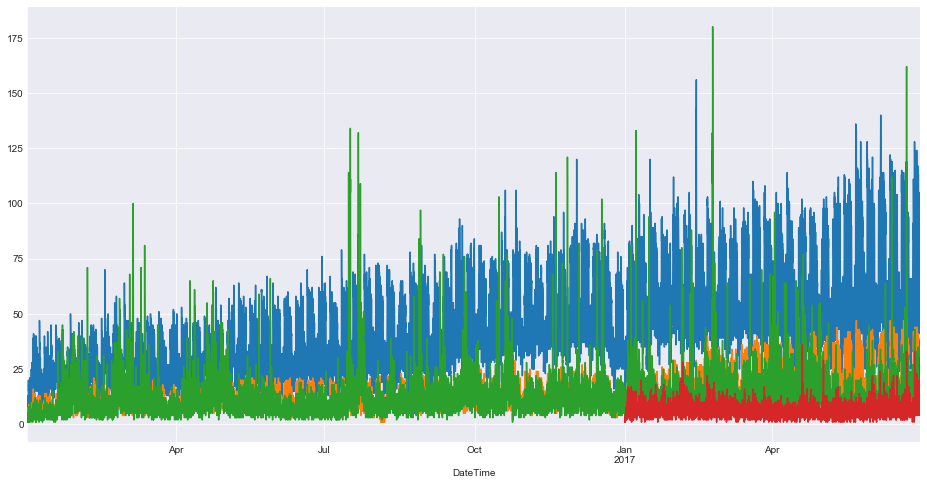

In [187]:
plt.figure(figsize = (16,8))

for i in train.Junction.unique():
    train[train.Junction==i].set_index('DateTime')['Vehicles'].plot()



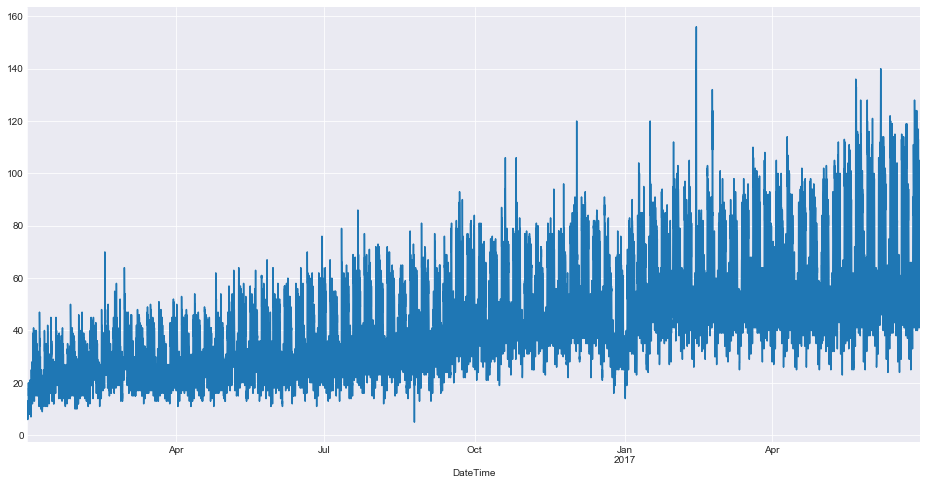

In [188]:
plt.figure(figsize = (16,8))

train[train.Junction==1].set_index('DateTime')['Vehicles'].plot()


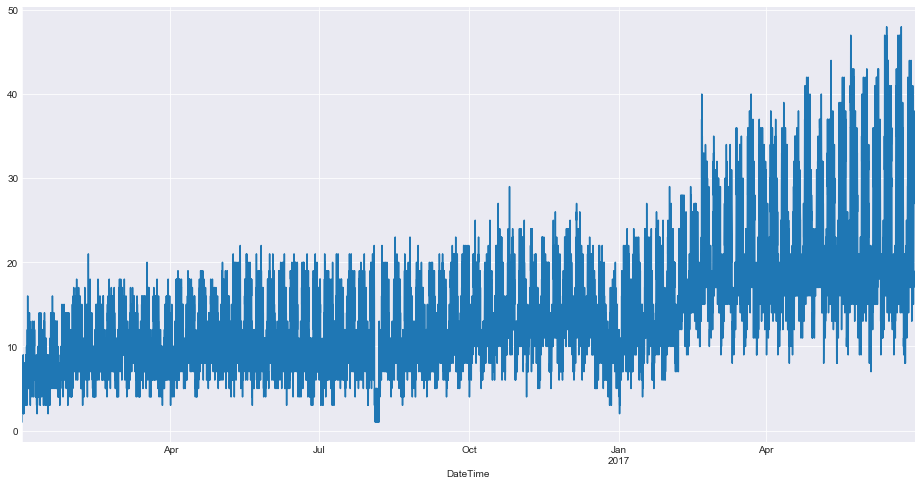

In [189]:
plt.figure(figsize = (16,8))

train[train.Junction==2].set_index('DateTime')['Vehicles'].plot()


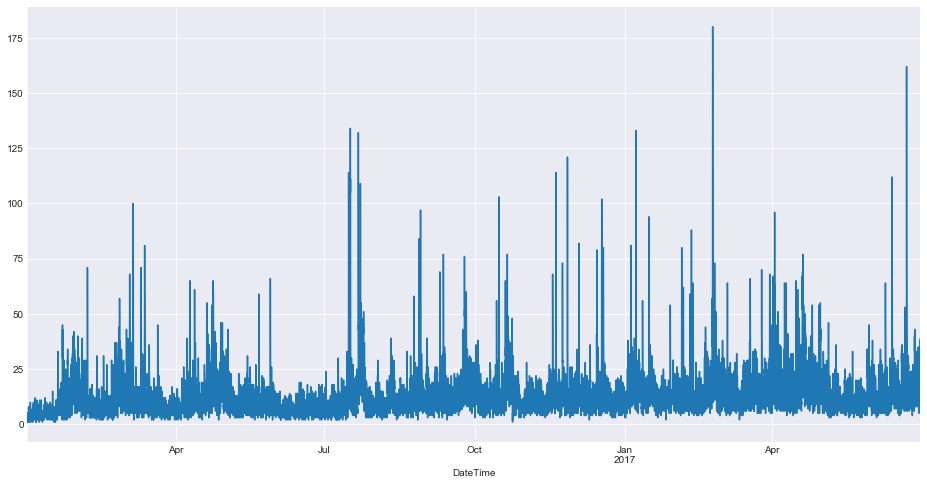

In [190]:

plt.figure(figsize = (16,8))

train[train.Junction==3].set_index('DateTime')['Vehicles'].plot()


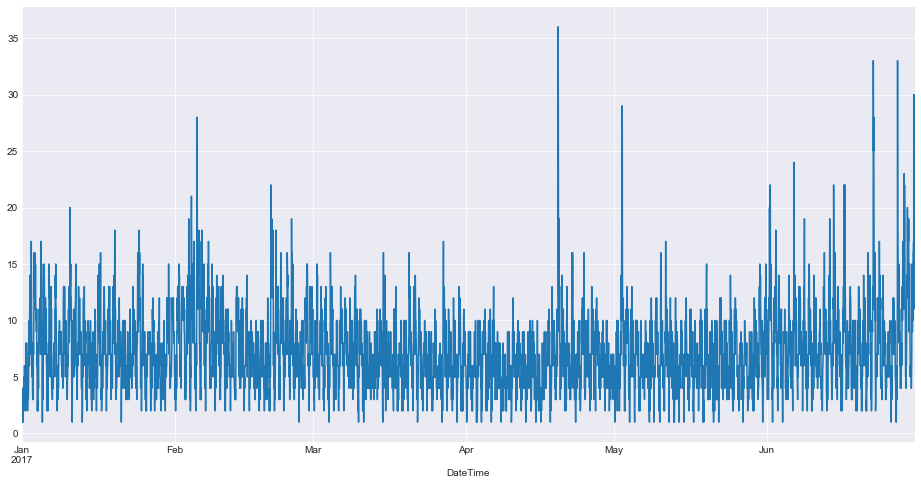

In [191]:
plt.figure(figsize = (16,8))

train[train.Junction==4].set_index('DateTime')['Vehicles'].plot()


In [192]:
test.isnull().sum()

DateTime    0
Junction    0
ID          0
dtype: int64

In [193]:

train['hour'] = train.DateTime.dt.hour
train['dow'] = train.DateTime.dt.dayofweek
train['dom'] = train.DateTime.dt.day
train['month'] = train.DateTime.dt.month
train['year'] = train.DateTime.dt.year

test['hour'] = test.DateTime.dt.hour
test['year'] = test.DateTime.dt.year
test['dom'] = test.DateTime.dt.day
test['month'] = test.DateTime.dt.month
test['dow'] = test.DateTime.dt.dayofweek

train['is_weekend'] = 0
test['is_weekend'] = 0

train.loc[train.dow >5, 'is_weekend'] = 1
test.loc[test.dow >5, 'is_weekend'] = 1


In [194]:
train['is_weekend'].value_counts()

0    37485
1     6240
Name: is_weekend, dtype: int64

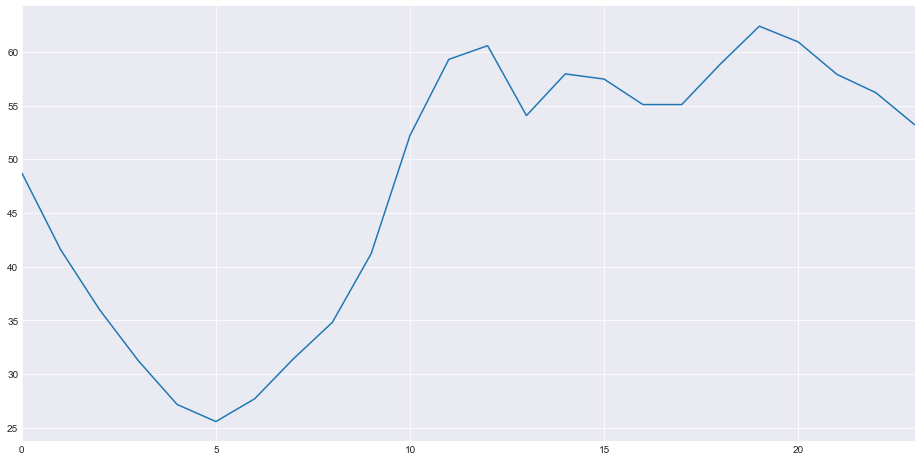

In [195]:
plt.figure(figsize = (16,8))

train[train.Junction==1].groupby('hour').Vehicles.mean().reset_index()['Vehicles'].plot()


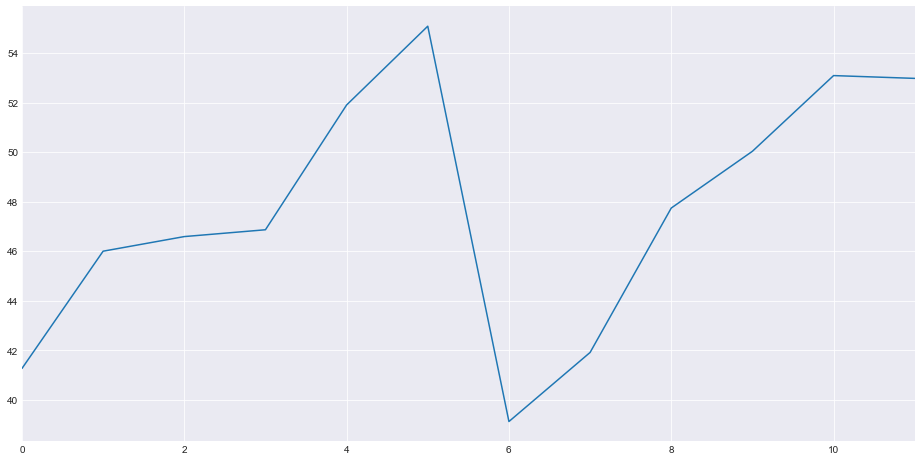

In [196]:
plt.figure(figsize = (16,8))

train[train.Junction==1].groupby('month').Vehicles.mean().reset_index()['Vehicles'].plot()


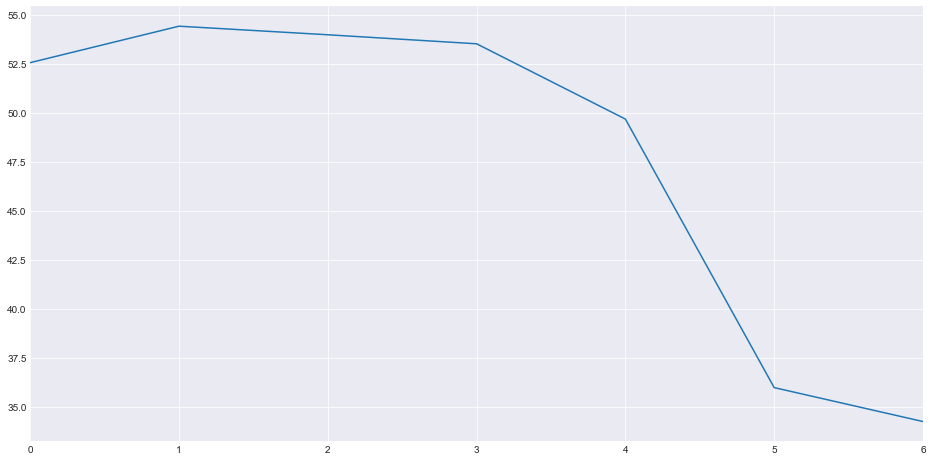

In [197]:
plt.figure(figsize = (16,8))

train[train.Junction==1].groupby('dow').Vehicles.mean().reset_index()['Vehicles'].plot()


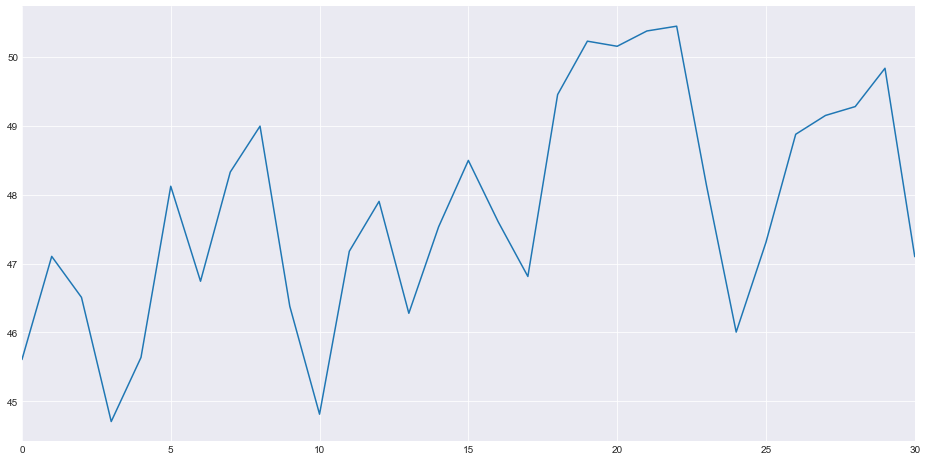

In [198]:
plt.figure(figsize = (16,8))

train[train.Junction==1].groupby('dom').Vehicles.mean().reset_index()['Vehicles'].plot()


In [199]:
train[train.Junction==1].groupby('month').Vehicles.mean().reset_index()


,month,Vehicles
0,1,41.268325
1,2,46.000731
2,3,46.590054
3,4,46.865278
4,5,51.899866
5,6,55.079167
6,7,39.127688
7,8,41.915323
8,9,47.741667
9,10,50.032258


In [200]:
stats_df = train.groupby('Junction').Vehicles.agg([np.mean, np.std, np.median, np.count_nonzero]).reset_index()

In [201]:
stats_df.head()

,Junction,mean,std,median,count_nonzero
0,1,47.777558,22.533528,43,13127
1,2,14.911937,7.438612,14,13127
2,3,14.604784,10.521006,12,13127
3,4,7.251611,3.521455,7,4344


In [202]:
train = train.merge(stats_df, on = 'Junction', how = 'left')
test = test.merge(stats_df, on = 'Junction', how = 'left')

In [203]:
train.head()

,DateTime,Junction,Vehicles,ID,hour,dow,dom,month,year,is_weekend,mean,std,median,count_nonzero
0,2016-01-01 01:00:00,1,13,20160101011,1,4,1,1,2016,0,47.777558,22.533528,43,13127
1,2016-01-01 02:00:00,1,11,20160101021,2,4,1,1,2016,0,47.777558,22.533528,43,13127
2,2016-01-01 03:00:00,1,6,20160101031,3,4,1,1,2016,0,47.777558,22.533528,43,13127
3,2016-01-01 04:00:00,1,8,20160101041,4,4,1,1,2016,0,47.777558,22.533528,43,13127
4,2016-01-01 05:00:00,1,6,20160101051,5,4,1,1,2016,0,47.777558,22.533528,43,13127


In [204]:
test.DateTime.describe()

count                   11808
unique                   2952
top       2017-09-27 15:00:00
freq                        4
first     2017-07-01 00:00:00
last      2017-10-31 23:00:00
Name: DateTime, dtype: object

In [205]:
train['is_train'] = 1
test['is_train'] = 0
test['Vehicles'] = -1

dt = pd.concat([train,test])

In [206]:
dt.head()

,DateTime,ID,Junction,Vehicles,count_nonzero,dom,dow,hour,is_train,is_weekend,mean,median,month,std,year
0,2016-01-01 01:00:00,20160101011,1,13,13127,1,4,1,1,0,47.777558,43,1,22.533528,2016
1,2016-01-01 02:00:00,20160101021,1,11,13127,1,4,2,1,0,47.777558,43,1,22.533528,2016
2,2016-01-01 03:00:00,20160101031,1,6,13127,1,4,3,1,0,47.777558,43,1,22.533528,2016
3,2016-01-01 04:00:00,20160101041,1,8,13127,1,4,4,1,0,47.777558,43,1,22.533528,2016
4,2016-01-01 05:00:00,20160101051,1,6,13127,1,4,5,1,0,47.777558,43,1,22.533528,2016


In [207]:

for i in dt.Junction.unique():
    dt.loc[dt.Junction==i,'4_month_ma'] = pd.rolling_mean(dt[dt.Junction==i].Vehicles, 24*31*4)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=2976,center=False).mean()
  This is separate from the ipykernel package so we can avoid doing imports until


In [208]:
dt.tail()

,DateTime,ID,Junction,Vehicles,count_nonzero,dom,dow,hour,is_train,is_weekend,mean,median,month,std,year,4_month_ma
11803,2017-10-31 19:00:00,20171031194,4,-1,4344,31,1,19,0,0,7.251611,7,10,3.521455,2017,-0.882056
11804,2017-10-31 20:00:00,20171031204,4,-1,4344,31,1,20,0,0,7.251611,7,10,3.521455,2017,-0.886761
11805,2017-10-31 21:00:00,20171031214,4,-1,4344,31,1,21,0,0,7.251611,7,10,3.521455,2017,-0.891129
11806,2017-10-31 22:00:00,20171031224,4,-1,4344,31,1,22,0,0,7.251611,7,10,3.521455,2017,-0.896505
11807,2017-10-31 23:00:00,20171031234,4,-1,4344,31,1,23,0,0,7.251611,7,10,3.521455,2017,-0.900538


In [209]:
#from pandas.tseries.holiday import USFederalHolidayCalendar

#cal = USFederalHolidayCalendar()
#holidays = cal.holidays(start=dt['DateTime'].min(),
#                        end=dt['DateTime'].max()).to_pydatetime()

#dt['holiday'] = dt['DateTime'].dt.date.astype('datetime64').isin(holidays).astype('float')


In [210]:
from datetime import datetime
from workalendar import usa


cal = usa.UnitedStates()

dt['holiday'] = dt['DateTime'].apply(lambda x: x.date()).apply(lambda x: cal.is_working_day(x)).astype('float')


In [211]:
dt.holiday.value_counts()

1.0    38232
0.0    17301
Name: holiday, dtype: int64

In [212]:
dt['365_days_lag'] = dt.groupby(['Junction'])['Vehicles'].shift(24*365)
dt['180_days_lag'] = dt.groupby(['Junction'])['Vehicles'].shift(24*180)
dt['100_days_lag'] = dt.groupby(['Junction'])['Vehicles'].shift(24*100)

In [213]:
train = dt[dt.is_train==1]
test = dt[dt.is_train==0]

In [214]:
train_val = train[train.DateTime <= '2017-03-30 23:00:00']
test_val = train[train.DateTime > '2017-03-30 23:00:00']

In [215]:
train_val.head()

,DateTime,ID,Junction,Vehicles,count_nonzero,dom,dow,hour,is_train,is_weekend,mean,median,month,std,year,4_month_ma,holiday,365_days_lag,180_days_lag,100_days_lag
0,2016-01-01 01:00:00,20160101011,1,13,13127,1,4,1,1,0,47.777558,43,1,22.533528,2016,NaN,0.0,NaN,NaN,NaN
1,2016-01-01 02:00:00,20160101021,1,11,13127,1,4,2,1,0,47.777558,43,1,22.533528,2016,NaN,0.0,NaN,NaN,NaN
2,2016-01-01 03:00:00,20160101031,1,6,13127,1,4,3,1,0,47.777558,43,1,22.533528,2016,NaN,0.0,NaN,NaN,NaN
3,2016-01-01 04:00:00,20160101041,1,8,13127,1,4,4,1,0,47.777558,43,1,22.533528,2016,NaN,0.0,NaN,NaN,NaN
4,2016-01-01 05:00:00,20160101051,1,6,13127,1,4,5,1,0,47.777558,43,1,22.533528,2016,NaN,0.0,NaN,NaN,NaN


In [216]:
train_val['ind'] = train_val.index
test_val['ind'] = test_val.index


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [217]:
train.columns

Index(['DateTime', 'ID', 'Junction', 'Vehicles', 'count_nonzero', 'dom', 'dow',
       'hour', 'is_train', 'is_weekend', 'mean', 'median', 'month', 'std',
       'year', '4_month_ma', 'holiday', '365_days_lag', '180_days_lag',
       '100_days_lag'],
      dtype='object')

In [220]:
predictors = ['Junction', 
              'dow', 
              'mean', 
              'hour',
              #'dom',
              #'median',
              #'std',
              #'month', 
              #'year',
              'ID',
              #'count_nonzero'
              #'ind'
              #'holiday'
              #'365_days_lag',
              #'180_days_lag', 
              #'100_days_lag'
              #'4_month_ma'
              #'is_weekend'
             ]

Outcome = 'Vehicles'

In [238]:


xgb_params = {
    'eta': 0.01,
    'max_depth': 5,
    'subsample': 0.6,
    'colsample_bytree': 1,
    'lambda': 3,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 0
}

#dtrain = xgb.DMatrix(data=train_val.loc[train_val.Vehicles<np.percentile(train_val.Vehicles,99.5),predictors], label= train_val.loc[train_val.Vehicles<np.percentile(train_val.Vehicles,99.5),Outcome])
dtrain = xgb.DMatrix(data=train_val.loc[:,predictors], label= train_val.loc[:,Outcome])
dtest = xgb.DMatrix(data=test_val.loc[:,predictors], label= test_val.loc[:,Outcome])

print(train_val.loc[:,predictors].shape)
print(train_val.loc[:,Outcome].shape)

print(test_val.loc[:,predictors].shape)
print(test_val.loc[:,Outcome].shape)


watchlist = [(dtrain, 'train'),(dtest, 'eval')]

num_rounds = 10000

model = xgb.train(xgb_params, dtrain, num_rounds, watchlist, early_stopping_rounds=50, verbose_eval=25)


(34893, 5)
(34893,)
(8832, 5)
(8832,)
[0]	train-rmse:28.8703	eval-rmse:39.4539
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 50 rounds.
[25]	train-rmse:22.8892	eval-rmse:32.1673
[50]	train-rmse:18.3145	eval-rmse:26.5649
[75]	train-rmse:14.8312	eval-rmse:22.2296
[100]	train-rmse:12.2103	eval-rmse:18.9424
[125]	train-rmse:10.2717	eval-rmse:16.4232
[150]	train-rmse:8.86157	eval-rmse:14.4536
[175]	train-rmse:7.85671	eval-rmse:12.9599
[200]	train-rmse:7.14758	eval-rmse:11.8312
[225]	train-rmse:6.65337	eval-rmse:10.9298
[250]	train-rmse:6.3056	eval-rmse:10.2738
[275]	train-rmse:6.06018	eval-rmse:9.7577
[300]	train-rmse:5.88702	eval-rmse:9.35569
[325]	train-rmse:5.75554	eval-rmse:9.04868
[350]	train-rmse:5.65868	eval-rmse:8.78495
[375]	train-rmse:5.58017	eval-rmse:8.57087
[400]	train-rmse:5.52022	eval-rmse:8.40867
[425]	train-rmse:5.46994	eval-rmse:8.26173
[450]	train-rmse:5.42498	eval-rmse:8.14944
[475]	tra

In [ ]:
[1328]	train-rmse:4.98139	eval-rmse:7.45861


In [759]:
1800/1328

1.355421686746988

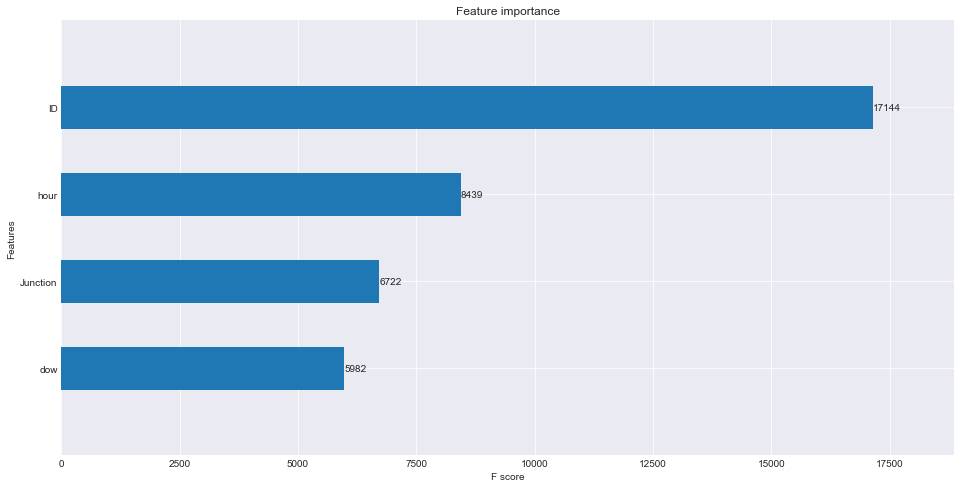

In [226]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
xgb.plot_importance(model, height=0.5, ax=ax)

In [240]:
dtrain = xgb.DMatrix(data=train.loc[:,predictors], label= train.loc[:,Outcome])
dtest = xgb.DMatrix(data=test.loc[:,predictors])

model = xgb.train(xgb_params, dtrain, num_boost_round = 1800)

In [241]:
preds[1:10]

array([ 58.9223175 ,  47.04116058,  38.08940506,  32.29788208,
        31.3237896 ,  32.83462143,  37.21841049,  41.23865128,  46.20049667], dtype=float32)

In [242]:

preds = model.predict(dtest)

df_sub = pd.DataFrame({'ID': test.ID, 'Vehicles': preds})

df_sub.to_csv('sub20.csv', index=False)


In [326]:
best_sub = pd.read_csv("sub20.csv")

best_sub['Vehicles'] = best_sub.Vehicles

best_sub.loc[test.Junction.isin([1]),'Vehicles'] = best_sub[test.Junction.isin([1])].Vehicles+0.07*best_sub[test.Junction.isin([1])].Vehicles
best_sub.loc[test.Junction.isin([2]),'Vehicles'] = best_sub[test.Junction.isin([2])].Vehicles+0.07*best_sub[test.Junction.isin([2])].Vehicles
best_sub.loc[test.Junction.isin([3]),'Vehicles'] = best_sub[test.Junction.isin([3])].Vehicles-0.09*best_sub[test.Junction.isin([3])].Vehicles
best_sub.loc[test.Junction.isin([4]),'Vehicles'] = best_sub[test.Junction.isin([4])].Vehicles-0.13*best_sub[test.Junction.isin([4])].Vehicles

best_sub.to_csv("best_sub.csv",index=False)

## Experiments:

In [847]:
predictors_lm = ['Junction', 
              'dow', 
              'mean', 
              'hour',
              'dom',
              #'median',
              #'std',
              'month', 
              'year',
              #'ID',
              'ind'
              #'holiday'
              #'365_days_lag',
              #'180_days_lag', 
              #'100_days_lag'
              #'4_month_ma'
              #'is_weekend'
             ]

Outcome = 'Vehicles'

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()

rf.fit(train_val.loc[:,predictors], train_val.loc[:,Outcome])

preds_rf = rf.predict(test_val.loc[:,predictors])

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

rmse(preds_rf, test_val[Outcome])

rf.fit(train.loc[:,predictors], train.loc[:,Outcome])

preds_rf = rf.predict(test.loc[:,predictors])

best_sub = pd.read_csv("sub14.csv")

rf_xgb_sub = best_sub

rf_xgb_sub.Vehicles = best_sub.Vehicles * 0.9 + preds_rf * 0.1

rf_xgb_sub.to_csv("rf_xgb_sub.csv", index=False)

In [848]:
from sklearn import datasets, linear_model

lm = linear_model.LinearRegression()

lm.fit(train_val.loc[:,predictors_lm].fillna(0), train_val.loc[:,Outcome])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [846]:
pred_lm = lm.predict(test_val.loc[:,predictors_lm].fillna(0))


def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

rmse(pred_lm, test_val[Outcome])

15.135773110788078

In [851]:
df_sub_lm.head()

,ID,Vehicles
0,20170701001,48.303032
1,20170701011,49.000892
2,20170701021,49.698751
3,20170701031,50.396611
4,20170701041,51.094471


In [852]:
best_sub = pd.read_csv("sub14.csv")

best_sub.head()

,ID,Vehicles
0,20170701001,68.042976
1,20170701011,59.017818
2,20170701021,47.136662
3,20170701031,38.101273
4,20170701041,32.301216


In [853]:
lm_xgb_sub = best_sub

lm_xgb_sub.Vehicles = best_sub.Vehicles * 0.9 + df_sub_lm.Vehicles * 0.1

lm_xgb_sub.head()

,ID,Vehicles
0,20170701001,66.068982
1,20170701011,58.016126
2,20170701021,47.392871
3,20170701031,39.330806
4,20170701041,34.180542


In [854]:
lm_xgb_sub.to_csv("lm_xgb_sub.csv", index=False)

In [43]:
predictors_c = ['Junction', 
              'dow', 
              'mean', 
              'hour',
              #'dom',
              #'median',
              #'std',
              #'month', 
              #'year',
              'ID',
              #'ind'
              #'holiday'
              #'365_days_lag',
              #'180_days_lag', 
              #'100_days_lag'
              #'4_month_ma'
              #'is_weekend'
             ]

Outcome = 'Vehicles'

In [52]:
from catboost import CatBoostRegressor

cat_features = [0]

# Initialize CatBoostRegressor
model = CatBoostRegressor(iterations=2, learning_rate=1, depth=2)

# Fit model
model.fit(train_val[predictors_c], train_val[Outcome], cat_features)

# Get predictions
preds_c = model.predict(test_val[predictors_c])

In [53]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

rmse(preds_c, test_val[Outcome])

15.097998278172817